# Week 07: Feed-forward Neural Networks with Backpropagation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# 7.1 Scaling
Let's first consider *feature scaling*, which is a useful tool for machine learning

To make it simple, we consider it in the context of (enhanced) linear regression. You should keep in mind, however, that it is equally relevant to classification as to regression. Also, feature scaling applies in similar ways to all learners using gradient descent.

To keep things even simpler, we will reuse a data set and some of the classes and methods we introduced in the exercise set week 07.

In the lectures, we mentioned the importance of scaling/normalizing/standardizing the data for the *k*NN algorithm. 
We will here consider why scaling is important for gradient descent-based algorithms. 
Let's see the effects of this on a real data example.

## Dataset

First, we'll load a dataset with features that intentionally vary in scale. "ex1data2.txt" (https://github.com/nex3z/machine-learning-exercise) is a dataset of housing prices, including the size of the house (in square feet), the number of bedrooms, and the price of the house in dollars.

For the record, 100 sqm is about the same as 1100 sq. feet.

In [2]:
data = np.loadtxt(open("ex1data2.txt", "r"), delimiter=",")

Let us inspect what the data looks like:

In [3]:
data[:10,:]

array([[2.10400e+03, 3.00000e+00, 3.99900e+05],
       [1.60000e+03, 3.00000e+00, 3.29900e+05],
       [2.40000e+03, 3.00000e+00, 3.69000e+05],
       [1.41600e+03, 2.00000e+00, 2.32000e+05],
       [3.00000e+03, 4.00000e+00, 5.39900e+05],
       [1.98500e+03, 4.00000e+00, 2.99900e+05],
       [1.53400e+03, 3.00000e+00, 3.14900e+05],
       [1.42700e+03, 3.00000e+00, 1.98999e+05],
       [1.38000e+03, 3.00000e+00, 2.12000e+05],
       [1.49400e+03, 3.00000e+00, 2.42500e+05]])

The goal is to predict the price from the size and the number of bedrooms, so we start by splitting the input data from the target values.

## Exercise 7.1.1: Linear regression without scaling

First, let's try to fit our `NumpyLinReg()` to the data. Experiment with various learning rates and number of epochs. Print the weights (coefficients). Try to predict the price of a 3-bedroom 1500 sq. feet house. What do you see?

In [4]:
class NumpyLinReg():

    def fit(self, X_train, t_train, lr = 0.1, epochs=10):
        """X_train is a NxM matrix, N data points, M features
        t_train is avector of length N,
        the targets values for the training data
        lr is the learning rate
        """
        
        (N, M) = X_train.shape
        X_train = add_bias(X_train)
        
        self.weights = weights = np.zeros(M + 1)
        
        for e in range(epochs):
            weights -= lr / N *  X_train.T @ (X_train @ weights - t_train)      
    
    def predict(self, X):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        Z = add_bias(X)
        return Z @ self.weights

In [5]:
def add_bias(X, bias=1):
    """X is a NxM matrix: N datapoints, M features
    Return a Nx(M+1) matrix with added bias in position zero"""
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of biases
    
    # Concatenate the column of bias in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [6]:
# Vector form solution for mean squared error
def mse_2(x,y):
    return sum((x - y)**2) / x.shape[0]

### Exercise 7.1.2: Implementing scaler

The reason for our problems is the large difference in scale between our two input features -- 3 orders of magnitude. A good idea could be to scale the data before you start to experiment. Implement a standard scaler (normalizer) and scale your data. By the way, it is only the input data `X2` which have to be scaled. It is normally not necessary to scale the output values `t2`/`y`.

### Exercise 7.1.3: Linear regresssion with scaling
Try to fit a linear regression to the scaled data. Experiment with various training rates and number of epochs. Print the weights (coefficients). Try to predict the price of a 3-bedroom 1500 sq. feet house. How does this go compared to the experiments without scaling?

# 7.2 Feed-forward Neural Networks
Now, we will try to approach a non-linear dataset with a simple feed-forward neural network with one hidden layer (a Multi-Layer Perceptron).

In [7]:
# The size of the dataset
N = 101
# The features of the dataset
xx = np.linspace(-5, 5, N)
xx[:10]

array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1])

For the y-features, we start with a third degree polynomial. We choose a polynomial which is further from linear.

In [8]:
polynom = xx**3 - 25*xx + 15

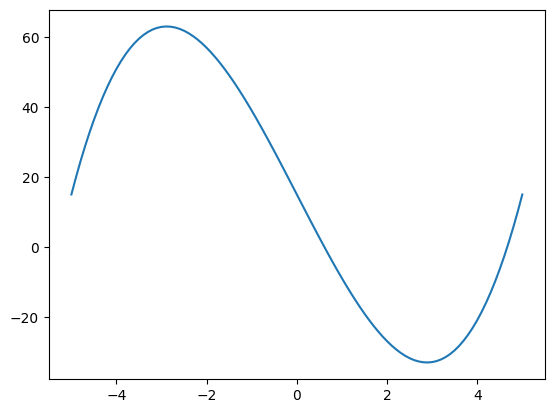

In [9]:
plt.plot(xx, polynom)

We add some "noise" to the smooth curve to generate the dataset. The underlying idea is that the smooth curve represents the function we are looking for, and that this is the best we can hope to learn. A solution which does better  on the training material than the smooth curve is probably overfitted and will not generalize as well to new data as the smooth curve. We are using a normal distribution to generate noise. The numpy function `normal` will generate a vector of `size` many random points around `loc` from a distribution with standard deviation `scale`.

Observe the `rng` prefix. This fix the seed such that we get the same dataset each time we run the notebook.

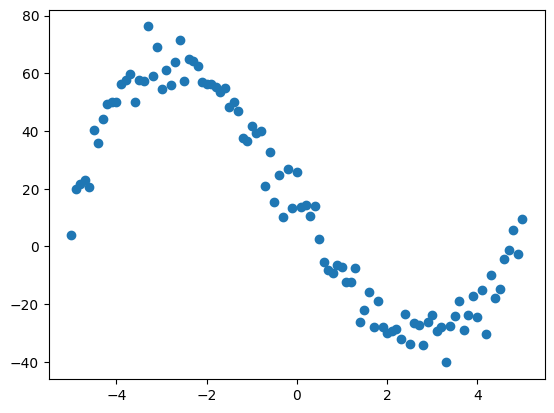

In [12]:
from numpy.random import normal
rng = np.random.default_rng(2025)
t = polynom + rng.normal(loc=0, scale=5, size=N)
plt.scatter(xx, t)

Our training data now consist of pairs (xx[i], t[i]), where xx[i] is the datapoint and t[i] the target value. So far, both `xx` and `t` are vectors. Check their shapes, e.g., `xx.shape`. The goal is to make an implementation for linear regression which works with an arbitrary number of input variables and not just one. We will therefore transform `xx` to a matrix of dimension $N\times m$ where each row represents one datapoint, and $m$ is the number of input variables (or features). Check the shape of `X` after the transform.

In [13]:
X = xx.reshape(-1,1)
X.shape

(101, 1)

## 7.2.1: Linear regression baseline

We start with implementing a simple linear regression model, as in week 7. Our aim is to find an approximate function that fits the data generated above.

Since we are dealing with only one input variable, we start with a simple linear function, $f(x_1) = w_0 + w_1x_1$.

We wonder if our $f$ fits the data well, and what parameters will give us the best approximation. We will estimate this using the Mean Squared Error:

$\frac{1}{N} \sum_{j=1}^{N} (t_j - \sum_{i=0}^{m} w_ix_{ji})^2$

In [14]:
# More efficient vector form solution
def mse_3(x,y):
    return np.mean((x - y)**2)

###  Excercise 7.2.1.1: Testing the MSE
To test our implementation, take the function $f(x)=0$ as a baseline and calculate the MSE for this $f$. 

Also calculate the Root Mean Square Error which provides a more natural measure for how good the fit is.

By the way, what is the MSE  and RMSE for the theoretical distribution?

### Excercise 7.2.1.2: Training and testing linear regresssion baseline
Fit the model to the training data. Report the coefficients. Plot the line together with the observations. Calculate the RMSE. Is the result a better fit than the baseline constant function $f(x)=0$?

## 7.2.2 MLP regression

Now, a simple feed-forward neural network with one hidden layer: a multi-layered perceptron, MLP.

### One item, one pass
We will add bias, and use bias=-1

In [15]:
Xb = add_bias(X, bias=-1)

In [16]:
Xb[:10]

array([[-1. , -5. ],
       [-1. , -4.9],
       [-1. , -4.8],
       [-1. , -4.7],
       [-1. , -4.6],
       [-1. , -4.5],
       [-1. , -4.4],
       [-1. , -4.3],
       [-1. , -4.2],
       [-1. , -4.1]])

We will follow one datapoint through the model. First prediction, then update weights (backpropagation).

We have chosen observation 25.

In [17]:
obs = 25
Xb[25]

array([-1. , -2.5])

In [18]:
t[25]

57.41642739729151

When you start training you should initialize the weights to random numbers small in absolute value.

Let's imagine we started to train the network in this way. We trained the network for small period. The weights in the matrices `V`, `W`, are the weights after this short training period. They are chosen as an example of weight matrices that may occur (early) during training. 

The current weights in matrix form:

In [19]:
V = np.array([[0.4, 0.2, 0.9],
            [-1.5, 2.0, -2.0]])
V

array([[ 0.4,  0.2,  0.9],
       [-1.5,  2. , -2. ]])

In [20]:
W = np.array([6, 3.0, -3, 4.2]).reshape(-1,1)
W

array([[ 6. ],
       [ 3. ],
       [-3. ],
       [ 4.2]])

We have to be aware whether we represent our observation as a vector of `shape=(2,)` or a row matrix of `shape=(1,2)`. Either of them can work. We have to be certain regarding the chosen format, however.

To use a row matrix will have two advantages:

- We reuse the code for batch processing
- One of the steps is most easily done by matrices.

Hence, we will use row matrices from the beginning.

In [21]:
obs = 25 # The observation we will  consider
x_obs = Xb[obs]
# A vector
x_obs

array([-1. , -2.5])

In [22]:
X_obs = Xb[obs:obs+1]
# A row matrix
X_obs

array([[-1. , -2.5]])

In [23]:
print(x_obs.shape)
print(X_obs.shape)

(2,)
(1, 2)


### Forward pass

Logistic activation function:

In [24]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

#### Hidden layer

In [25]:
hidden_in = X_obs @ V
hidden_in

array([[ 3.35, -5.2 ,  4.1 ]])

In [26]:
hidden_out = logistic(hidden_in)
hidden_out

array([[0.96610484, 0.0054863 , 0.9836975 ]])

#### Excercise 7.2.2.1: Implementing the final layer

We have the hidden layer, now finalize the neural network implementation. 
You should add biases to the output of the hidden layer, and then create the output layer `final_in=final_out=Y_obs` by applying weights `W` to the hidden layer.

#### The current weights

In [ ]:
# The generated dataset
plt.scatter(X, t)
plt.plot(X[obs], t[obs], "rx", label="target")
plt.plot(X[obs], Y_obs, "gx", label="predicted")
plt.legend()

We can also check the predictions for other points.

In [28]:
Y = add_bias(logistic(Xb @ V), -1) @ W

In [ ]:
# The generated dataset
plt.scatter(X, t)
plt.plot(X[obs], t[obs], "rx", label="target")
plt.plot(X[obs], Y_obs, "gx", label="predicted")
plt.plot(X,Y, "g", label="model")
plt.legend()

### Backpropagation pass

In [30]:
t[obs]

57.41642739729151

We use 0.5*MSE as our loss

In [ ]:
loss = 0.5 * (Y_obs-t[obs])**2
loss

#### The last layer

In [ ]:
final_delta = (Y_obs - t[obs])
final_delta

We have what is needed for updating the Ws. But we have to wait until we have found the delta terms for the first layer.

Observe that `A=hidden_out` has shape (1, 4), a row matrix, while W has shape (4, 1), a column matrix. Hence, we have to reshape A.

The form `reshape((-1,1))` will reshape a matrix of shape `(m, n)` to matrix of shape `(m*n, 1)`.

In [33]:
# W -= lr * final_delta * hidden_out.reshape((-1,1))

In [34]:
hidden_out.shape

(1, 3)

In [35]:
hidden_out.reshape((-1,1))

array([[0.96610484],
       [0.0054863 ],
       [0.9836975 ]])

#### The hidden layer

In [ ]:
hidden_out_delta = final_delta[0,0] * W.T
hidden_out_delta

In [ ]:
hidden_out_delta = final_delta @ W.T
hidden_out_delta

We remove the part which corresponds to the bias in the hidden layer when we are going backwards through the hidden layer. It is important to remember where you put the bias - first or last in the vectors.

In [ ]:
a = hidden_out[:, 1:]
hidden_in_delta = a * (1 - a) * hidden_out_delta[:, 1:]
hidden_in_delta

#### Excercise 7.2.2.2: Updating MLP weights
Now, that you have all the deltas, do one step of updating the neural network weights.

### Stochastic gradient descent

We gather the code from the forward pass and backprogation pass for one observation in one cell. To see that we have copied everything correctly, we reset the weights, run everything, and see that the updated weights are the same.

In [38]:
V = np.array([[0.4, 0.2, 0.9],
            [-1.5, 2.0, -2.0]])
W = np.array([6, 3.0, -3, 4.2]).reshape(-1,1)

lr = 0.01
obs = 25
X_obs = Xb[obs:obs+1]

hidden_in = X_obs @ V

hidden_out = logistic(hidden_in)

hidden_out = add_bias(hidden_out, -1)

final_in = hidden_out @ W

Y_obs = final_out = final_in


### Backprop

t[obs]

final_delta = (Y_obs - t[obs])

# hidden_out_delta = final_delta @ W.T

hidden_out_delta = final_delta[0,0] * W.T

a = hidden_out[:,1:]

hidden_in_delta = a * (1 -a) * hidden_out_delta[:,1:]

W -= lr * final_delta * hidden_out.reshape((-1,1))
print("W: ")
print(W)

V -= lr * X_obs.T @ hidden_in_delta
print("\nV: ")
print(V)

W: 
[[ 5.43596958]
 [ 3.54491252]
 [-2.99690556]
 [ 4.75483532]]

V: 
[[ 0.3445903   0.20923239  0.86201015]
 [-1.63852424  2.02308097 -2.09497463]]


### Excercise 7.2.2.3
Turn it into *stochastic gradient descent* by running the code repeatedly. For each iteration, choose a random point (instance) from the dataset. 

Choose a smaller learning rate than in the step-by-step example. Try to run it with various numbers of iterations and various learning rates. Plot the results. Is it better than the linear approximation?

## The number of hidden nodes

### Excercise 7.2.2.4: Batch processing

We are interested whether we can get a better approximation with a larger number of nodes in the hidden layer. 
Implement a `MLPBinaryLinReg()` class using batch processing and having the number of hidden nodes as a parameter.
The class should have `fit()`, `forward()` and `predict()` methods.

In [39]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def logistic_diff(y):
    return y * (1 - y)

#### 3 hidden nodes

First, we try to train with three hidden nodes, and compare to the stochastic gradient descent algorithm.

In [ ]:
regr = MLPBinaryLinReg(bias=-1, dim_hidden=3)
regr.fit(X, t, epochs=50000, lr=0.001)
Y=regr.predict(X)

plt.scatter(X, t)
plt.plot(X, Y, "g")

In [ ]:
error = mse_2(t, Y)
print("MSE: ", error)

In [ ]:
print("RMSE :", np.sqrt(error))

### 12 hidden nodes

In [ ]:
regr = MLPBinaryLinReg(bias=-1, dim_hidden=12)
regr.fit(X, t, epochs=50000, lr=0.0001)
Y=regr.predict(X)

plt.scatter(X, t)
plt.plot(X, Y, "g")

In [ ]:
error = mse_2(t, Y)
print("MSE: ", error)

In [ ]:
print("RMSE :", np.sqrt(error))

In [ ]:
%%time

regr = MLPBinaryLinReg(bias=-1, dim_hidden=12)
regr.fit(X, t, epochs=500000, lr=0.0001)
Y=regr.predict(X)

plt.scatter(X, t)
plt.plot(X, Y, "g")

In [ ]:
error = mse_2(t, Y)
print("MSE: ", error)

In [ ]:
print("RMSE :", np.sqrt(error))

In [ ]:
%%time

regr = MLPBinaryLinReg(bias=-1, dim_hidden=12)
regr.fit(X, t, epochs=50000, lr=0.001)
Y=regr.predict(X)

plt.scatter(X, t)
plt.plot(X, Y, "g")

In [ ]:
error = mse_2(t, Y)
print("MSE: ", error)

In [ ]:
print("RMSE :", np.sqrt(error))

In [ ]:
%%time

regr = MLPBinaryLinReg(bias=-1, dim_hidden=12)
regr.fit(X, t, epochs=500000, lr=0.001)
Y=regr.predict(X)

plt.scatter(X, t)
plt.plot(X, Y, "g")

In [ ]:
error = mse_2(t, Y)
print("MSE: ", error)

In [ ]:
print("RMSE :", np.sqrt(error))

What happens if we increase the number of hidden nodes further?

### 100 hidden nodes

In [ ]:
%%time

regr = MLPBinaryLinReg(bias=-1, dim_hidden=100)
regr.fit(X, t, epochs=50000, lr=0.001)
Y=regr.predict(X)

plt.scatter(X, t)
plt.plot(X, Y, "g")

In [ ]:
error = mse_2(t, Y)
print("MSE: ", error)

In [ ]:
print("RMSE :", np.sqrt(error))

NB: all the experiments with MLP + linear regression are easily transformed into MLP + classification.